# TabTransformer

## Import libraries

In [1]:
import itertools
import pickle
import random
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

## Setting device and seed

In [2]:
SEED = 42


def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower


fix_random(SEED)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('Using device:', device)

Using device: cuda


## Model definition

In [3]:
class TabTransformer(nn.Module):
    def __init__(self, cat_dims, num_numerical, num_classes, dim_embedding=8, num_heads=2, num_layers=2, dropout=0.1, hidden_size=None):
        """
        Args:
            cat_dims: List of integers, dove ogni elemento rappresenta i valori unici di una colonna categoriale.
            num_numerical: Numero di caratteristiche numeriche.
            num_classes: Numero di classi per output.
            dim_embedding: Dimensione degli embeddings.
            num_heads: Numero di "head" nel Multi-Head Attention.
            num_layers: Numero di livelli Transformer.
            dropout: Dropout per prevenire overfitting.
        """
        super(TabTransformer, self).__init__()

        # Embeddings per features categoriali
        self.embeddings = nn.ModuleList([
            nn.Embedding(cat_dim, dim_embedding) for cat_dim in cat_dims
        ])

        # Layer per le features numeriche
        self.numerical_norm = nn.LayerNorm(num_numerical) if num_numerical > 0 else None

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_embedding,
            nhead=num_heads,
            dim_feedforward=dim_embedding * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classificatore finale
        self.classifier = nn.Sequential(
            nn.Linear(len(cat_dims) * dim_embedding + (num_numerical if num_numerical > 0 else 0), hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x_cat, x_num):
        """
        Args:
            x_cat: Tensore (batch_size, num_categorical_features), indici per features categoriali.
            x_num: Tensore (batch_size, num_numerical_features), valori numerici.
        Returns:
            Logits (batch_size, num_classes).
        """
        # Embedding per features categoriali
        x_cat = x_cat.long()
        cat_embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        cat_embeddings = torch.stack(cat_embeddings, dim=1)  # (batch_size, num_categorical_features, dim_embedding)

        # Passa attraverso il Transformer
        transformed_cat = self.transformer(cat_embeddings)  # (batch_size, num_categorical_features, dim_embedding)
        transformed_cat = transformed_cat.view(transformed_cat.size(0), -1)  # Flatten per concatenare

        # Normalizzazione delle features numeriche
        if x_num is not None and self.numerical_norm is not None:
            x_num = self.numerical_norm(x_num)

        # Concatenazione
        if x_num is not None:
            x = torch.cat([transformed_cat, x_num], dim=1)
        else:
            x = transformed_cat

        # Classificatore
        logits = self.classifier(x)
        return logits


class PyTorchTabTransformerWrapper:
    def __init__(self, model, cat_idx, num_idx, device='cpu'):
        self.model = model
        self.device = device
        self.model.to(self.device)
        self.cat_idx = cat_idx
        self.num_idx = num_idx

    def predict(self, X):
        """
        Esegue le previsioni sul modello PyTorch.
        """
        self.model.eval()  # Modalità di valutazione
        with torch.no_grad():
            # Controlla se X è un array numpy e convertilo in un tensore PyTorch
            if isinstance(X, np.ndarray):
                X = torch.tensor(X, dtype=torch.float32).to(self.device)

            # Supponi che X sia diviso in categoriale e numerico
            y_pred = self.model(X[:, self.cat_idx].long(),
                                X[:, self.num_idx])
            return torch.argmax(y_pred, dim=1).cpu().numpy()

## Training and test utilities

In [4]:
def train_model(model, criterion, optimizer, epochs, data_loader, val_loader, device, scheduler, patience):
    # Initialize best validation loss and epochs since last improvement
    best_val_loss = float('inf')
    epochs_since_last_improvement = 0

    # Record the start time
    start = time.time()

    # Initialize lists to store loss history
    loss_history = []
    val_loss_history = []

    # Loop over epochs
    for epoch in range(epochs):
        # Set the model to training mode
        model.train()

        # Record the start time of the epoch
        start_epoch = time.time()

        # Initialize training loss for the epoch
        loss_train = 0

        # Loop over batches in the data loader
        for x_cat, x_num, targets in data_loader:
            # Move data to the specified device (CPU or GPU)
            x_cat, x_num, targets = x_cat.to(device), x_num.to(device), targets.to(device)
            optimizer.zero_grad()
            # Forward pass
            outputs = model(x_cat, x_num)
            # Compute loss
            loss = criterion(outputs, targets.long())
            # Backward pass
            loss.backward()
            # Update weights
            optimizer.step()
            loss_train += loss.item()

        # Step the learning rate scheduler
        scheduler.step()
        loss_train /= len(data_loader)

        # Compute validation loss
        val_loss, y_pred, y_true = test_model(model, criterion, val_loader)

        loss_history.append(loss_train)
        val_loss_history.append(val_loss)

        # Calculate balanced accuracy
        balanced_accuracy = balanced_accuracy_score(
            y_true.detach().cpu().numpy(),
            y_pred.detach().cpu().numpy()
        )
        print(f'Epoch [{epoch}/{epochs}] - {time.time() - start_epoch:.2f} seconds - Train Loss: {loss_train:.6f} - Val Loss: {val_loss:.6f} - Val Balanced Accuracy: {balanced_accuracy:.6f}')

        # Early stopping with threshold
        threshold = 0.01
        if val_loss < best_val_loss - threshold:
            best_val_loss = val_loss
            torch.save(model, f"{filepath}/models/model_best_tf.save")
            epochs_since_last_improvement = 0
        elif epochs_since_last_improvement >= patience:
            break
        else:
            epochs_since_last_improvement += 1

    print('\nTraining ended after {:.2f} seconds - Best val_loss: {:.6f}'.format(time.time() - start, best_val_loss))
    # Load the best model
    best_model = torch.load(f"{filepath}/models/model_best_tf.save")
    return best_model, loss_history, val_loss_history, best_val_loss


def test_model(model, criterion, loader):
    # Set the model to evaluation mode
    model.eval()
    y_pred = []
    y_true = []

    total_loss = 0.0

    # Turn off gradient tracking
    with torch.no_grad():
        for x_cat, x_num, targets in loader:
            # Move data to the specified device (CPU or GPU)
            x_cat, x_num, targets = x_cat.to(device), x_num.to(device), targets.to(device)
            # Outputs logits or probabilities
            preds = model(x_cat, x_num)

            # Compute loss
            loss = criterion(preds, targets.long())
            total_loss += loss.item()

            # Convert predictions to class labels
            predicted_classes = torch.argmax(preds, dim=1)

            # Accumulate predictions and targets
            y_pred.append(predicted_classes.cpu())
            y_true.append(targets.cpu())

    # Concatenate tensors only after the loop to minimize memory usage
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)

    # Calculate average loss
    avg_loss = total_loss / len(loader)
    return avg_loss, y_pred, y_true


def evaluate_model(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    return {"acc": acc, "bacc": bacc, "f1": f1}

## Define train, validation

In [11]:
save_in_test_folder = True
if save_in_test_folder:
    filepath = "../TestModule"
else:
    filepath = ".."

FILENAME = "dataset/train_dataset.csv"

#Prepare train data
df1 = pd.read_csv(FILENAME, sep=",", low_memory=False)

# Extract relevant features excluding specified columns
features_to_retain = df1.columns.difference(["label", "ts", "type", "http_referrer"]).tolist()
df1 = df1[features_to_retain + ["type"]]

print("#Righe: " + str(df1.shape[0]) + " #Colonne: " + str(df1.shape[1]))

# Converte i valori in numeri, sostituendo quelli non validi con NaN
df1["src_bytes"] = pd.to_numeric(df1["src_bytes"], errors='coerce')
# Filtra le righe con NaN (valori non convertibili)
df1 = df1.dropna(subset=["src_bytes"])
# Converte i valori rimasti in interi
df1.loc[:, "src_bytes"] = df1["src_bytes"].astype(int)

df1 = df1.dropna()
print("Dopo drop NaN")
print("#Righe: " + str(df1.shape[0]) + " #Colonne: " + str(df1.shape[1]))

features = df1.columns.difference(["type"]).tolist()
X = df1[features]
y = df1["type"]

with open(f"{filepath}/transformer/target_encoder.save", "rb") as f:
    le: preprocessing.LabelEncoder = pickle.load(f)

num_classes = len(le.classes_)
y = le.transform(y)

# Separate indices
indices = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=y, random_state=SEED)

# Take only X with index in val_idx
X_val = X.iloc[val_idx]
y_val = y[val_idx]

# Take only X with index in train_idx
X_train = X.iloc[train_idx]
y_train = y[train_idx]

#Righe: 617002 #Colonne: 43
Dopo drop NaN
#Righe: 616983 #Colonne: 43


## Preprocessing

In [12]:
class CustomOrdinalEncoder(OrdinalEncoder):
    def transform(self, X):
        encoded = super().transform(X)
        # Shift all values by +1 and replace unknown_value (-1) with 0
        return np.where(encoded == -1, 0, encoded + 1)

    def inverse_transform(self, X):
        # Handle the inverse transform to account for the +1 offset
        X = np.where(X == 0, -1, X - 1)
        return super().inverse_transform(X)


def preprocess(X_train, X_val, save=False):
    categorical_columns = X_train.select_dtypes(include=["object"]).columns.tolist()
    numeric_columns = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

    ct = ColumnTransformer(
        [
            ("cat", CustomOrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns),  # Trasforma le colonne categoriche
            ("scale", StandardScaler(), numeric_columns)  # Normalizza le colonne numeriche
        ],
        remainder="passthrough"  # Mantieni le altre colonne invariate
    )
    ct.set_output(transform="pandas")
    ct = ct.fit(X_train)

    if save:
        with open(f"{filepath}/transformer/transformer_tf.save", "wb") as f:
            pickle.dump(ct, f)

    # train set
    X_train = ct.transform(X_train)

    cat_idxs = [i for i, f in enumerate(X_train.columns) if "cat__" in f]
    cat_dims = [len(X_train[f].unique()) + 1 for i, f in enumerate(X_train.columns) if "cat__" in f]
    num_idxs = [i for i, f in enumerate(X_train.columns) if "scale__" in f]
    numeric_columns_number = len(num_idxs)

    X_train = X_train.to_numpy()

    # validation set
    X_val = ct.transform(X_val).to_numpy()
    return X_train, X_val, cat_idxs, cat_dims, num_idxs, numeric_columns_number

## Create DataLoader

In [7]:
class TabDataset(torch.utils.data.Dataset):
    def __init__(self, x_cat, x_num, y):
        self.x_cat = x_cat
        self.x_num = x_num
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x_cat[idx], self.x_num[idx], self.y[idx]

def create_datasets(X_train, y_train, X_val, y_val, cat_idxs, num_idxs):
    # Convert training data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    # Convert validation data to PyTorch tensors
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # Filter the categorical and numerical features for training data
    X_cat_train = X_train_tensor[:, cat_idxs]
    X_num_train = X_train_tensor[:, num_idxs]

    # Filter the categorical and numerical features for validation data
    X_cat_val = X_val_tensor[:, cat_idxs].long()
    X_num_val = X_val_tensor[:, num_idxs]

    # Create the dataset for training and validation
    train_dataset = TabDataset(X_cat_train, X_num_train, y_train_tensor)
    val_dataset = TabDataset(X_cat_val, X_num_val, y_val_tensor)

    return train_dataset, val_dataset

## Hyperparameters configuration

In [8]:
nums_epochs = [1000]
batch_sizes = [512, 1024]
patience = [20]
dim_embedding = [8, 16]
num_heads = [4, 8]
num_layers = [2, 4]
hidden_sizes = [64, 128]
learning_rate = [0.01, 0.001]
dropout = [0, 0.3]
hyperparameters = list(itertools.product(nums_epochs, batch_sizes, hidden_sizes, patience, dim_embedding, num_heads, num_layers, learning_rate, dropout))
n_comb = len(hyperparameters)
print(f'Number of hyperparameter combinations: {n_comb}')

Number of hyperparameter combinations: 128


# Hyperparameter tuning

In [9]:
kf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)

# Initialize the model, loss, and optimizer
best_loss = float('inf')
current_iter = 0
for epochs, batch_size, hidden_size, patience_, dim_embedding_, num_heads_, num_layers_, lr, dropout in hyperparameters:
    fix_random(SEED)
    start = time.time()

    print(f'Iteration {current_iter + 1}/{n_comb} - Hyperparameters: epochs={epochs}, batch_size={batch_size}, hidden_size={hidden_size}, patience={patience_}, dim_embedding={dim_embedding_}, num_heads={num_heads_}, num_layers={num_layers_}, lr={lr}, dropout={dropout}')

    log_name = f"B{batch_size}-hidden{hidden_size}-pat{patience_}-dim{dim_embedding_}-heads{num_heads_}-layers{num_layers_}-lr{lr}-drop{dropout}"

    writer = SummaryWriter('runs/tab_transformer/' + log_name)
    accuracy_per_fold = []
    balanced_accuracy_score_per_fold = []
    f1_score_per_fold = []
    best_loss_per_fold = []

    fold = 1

    for train_index, val_index in kf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        X_train_fold, X_val_fold, cat_idxs_fold, cat_dims_fold, num_idxs_fold, numeric_columns_number_fold = preprocess(X_train_fold, X_val_fold)

        train_dataset_fold, val_dataset_fold = create_datasets(X_train_fold, y_train_fold, X_val_fold, y_val_fold, cat_idxs_fold, num_idxs_fold)

        train_loader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)
        val_loader_fold = DataLoader(val_dataset_fold, batch_size=batch_size)

        # Modello TabTransformer
        model = TabTransformer(cat_dims_fold, numeric_columns_number_fold, num_classes, dim_embedding=dim_embedding_, num_heads=num_heads_, num_layers=num_layers_, dropout=dropout, hidden_size=hidden_size).to(device)

        class_weights_fold = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_fold), y=y_train_fold)
        class_weights_fold = dict(enumerate(class_weights_fold))

        criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_fold.values()), dtype=torch.float32).to(device))
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

        # Training
        model, loss_history, val_loss_history, best_loss_per_fold = train_model(
            model, criterion, optimizer, epochs, train_loader_fold, val_loader_fold, device, scheduler, patience_
        )

        # Validation
        val_loss, y_pred, y_true = test_model(model, criterion, val_loader_fold)
        perf = evaluate_model(y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy())

        print(f"Fold {fold} - Accuracy: {perf['acc']:.2f}%")
        print(f"Fold {fold} - Balanced Accuracy: {perf['bacc']:.2f}%")
        print(f"Fold {fold} - F1 Score: {perf['f1']:.2f}%")

        accuracy_per_fold.append(perf["acc"])
        balanced_accuracy_score_per_fold.append(perf["bacc"])
        f1_score_per_fold.append(perf["f1"])
        best_loss_per_fold.append(best_loss)
        fold += 1

    # Riassunto dei risultati
    print("Cross-Validation Results:")
    print(f"Average Accuracy: {np.mean(accuracy_per_fold) * 100:.2f}%")
    print(f"Standard Deviation of Accuracy: {np.std(accuracy_per_fold) * 100:.2f}%")
    print(f"Average Balanced Accuracy: {np.mean(balanced_accuracy_score_per_fold) * 100:.2f}%")
    print(f"Standard Deviation of Balanced Accuracy: {np.std(balanced_accuracy_score_per_fold) * 100:.2f}%")
    print(f"Average F1 Score: {np.mean(f1_score_per_fold) * 100:.2f}%")
    print(f"Standard Deviation of F1 Score: {np.std(f1_score_per_fold) * 100:.2f}%")

    # Close tensorboard writer after a training
    # Log hyperparameters and metrics to TensorBoard
    writer.add_hparams(
        {
            'hparam/bsize': batch_size,
            'hparam/hidden_size': hidden_size,
            'hparam/epochs': epochs,
            'hparam/patience': patience_,
            'hparam/dim_embedding': dim_embedding_,
            'hparam/num_heads': num_heads_,
            'hparam/num_layers': num_layers_,
            'hparam/lr': lr,
            'hparam/dropout': dropout
        },
        {
            'Best Loss': np.mean(best_loss_per_fold),
            'Avg Accuracy': np.mean(accuracy_per_fold),
            'Std Accuracy': np.std(accuracy_per_fold),
            'Avg Balanced Accuracy': np.mean(balanced_accuracy_score_per_fold),
            'Std Balanced Accuracy': np.std(balanced_accuracy_score_per_fold),
            'Avg F1 score': np.mean(f1_score_per_fold),
            'Std F1 score': np.std(f1_score_per_fold)
        }
    )
    writer.flush()
    current_iter += 1
    writer.close()

Iteration 1/128 - Hyperparameters: epochs=1000, batch_size=512, hidden_size=64, patience=20, dim_embedding=8, num_heads=4, num_layers=2, lr=0.01, dropout=0


C:\Users\miaob\PycharmProjects\DataAnalyticsProject\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [0/1000] - 40.52 seconds - Train Loss: 0.280117 - Val Loss: 0.263549 - Val Balanced Accuracy: 0.934718
Epoch [1/1000] - 40.12 seconds - Train Loss: 0.138882 - Val Loss: 0.130698 - Val Balanced Accuracy: 0.948677
Epoch [2/1000] - 42.10 seconds - Train Loss: 0.106272 - Val Loss: 0.170121 - Val Balanced Accuracy: 0.956101


KeyboardInterrupt: 

# Training final model
### Define weights for unbalanced classes

In [8]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 4.069469865611345, 1: 0.3381003918130257, 2: 1.132545546326465, 3: 4.543735616312253, 4: 98.7172, 5: 2.9863625363020327, 6: 1.1966881637007225, 7: 63.85329883570505, 8: 0.28803534018428717, 9: 0.9751965859248429}


### Train

In [9]:
nums_epochs = 1000
batch_sizes = 1024
patience = 20
dim_embedding = 16
num_heads = 8
num_layers = 4
hidden_sizes = 128
learning_rate = 0.001
dropout = 0


# Preprocessing
X_train, X_val, cat_idxs, cat_dims, num_idxs, numeric_columns_number = preprocess(X_train, X_val, save=True)

# Modello TabTransformer
model = TabTransformer(cat_dims, numeric_columns_number, num_classes, dim_embedding=dim_embedding, num_heads=num_heads, num_layers=num_layers, dropout=dropout, hidden_size=hidden_sizes).to(device)

criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()), dtype=torch.float32).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

train_dataset, val_dataset = create_datasets(X_train, y_train, X_val, y_val, cat_idxs, num_idxs)

train_loader = DataLoader(train_dataset, batch_size=batch_sizes, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_sizes)

model, loss_history, val_loss_history, best_loss = train_model(
    model, criterion, optimizer, nums_epochs, train_loader, val_loader, device, scheduler, patience
)

val_loss, y_pred, y_true = test_model(model, criterion, val_loader)
perf = evaluate_model(y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
print(f"Accuracy: {perf['acc']:.7f}%")
print(f"Balanced Accuracy: {perf['bacc']:.7f}%")
print(f"F1 Score: {perf['f1']:.7f}%")

with open(f"{filepath}/models/tf.save", "wb") as f:
    wrapped_model = PyTorchTabTransformerWrapper(model, cat_idxs, num_idxs)
    pickle.dump(wrapped_model, f)

C:\Users\miaob\PycharmProjects\DataAnalyticsProject\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [0/1000] - 79.69 seconds - Train Loss: 0.369596 - Val Loss: 0.170598 - Val Balanced Accuracy: 0.934658
Epoch [1/1000] - 81.52 seconds - Train Loss: 0.128152 - Val Loss: 0.130987 - Val Balanced Accuracy: 0.946693
Epoch [2/1000] - 80.12 seconds - Train Loss: 0.101529 - Val Loss: 0.106721 - Val Balanced Accuracy: 0.961531
Epoch [3/1000] - 78.78 seconds - Train Loss: 0.086029 - Val Loss: 0.148470 - Val Balanced Accuracy: 0.926864
Epoch [4/1000] - 80.84 seconds - Train Loss: 0.081851 - Val Loss: 0.087949 - Val Balanced Accuracy: 0.961556
Epoch [5/1000] - 81.12 seconds - Train Loss: 0.078054 - Val Loss: 0.073106 - Val Balanced Accuracy: 0.971046
Epoch [6/1000] - 78.97 seconds - Train Loss: 0.071989 - Val Loss: 0.112734 - Val Balanced Accuracy: 0.956147
Epoch [7/1000] - 81.49 seconds - Train Loss: 0.068518 - Val Loss: 0.084484 - Val Balanced Accuracy: 0.964273
Epoch [8/1000] - 80.71 seconds - Train Loss: 0.062639 - Val Loss: 0.079101 - Val Balanced Accuracy: 0.976346
Epoch [9/1000] - 78

### Plot 
Plot loss history and validation loss history

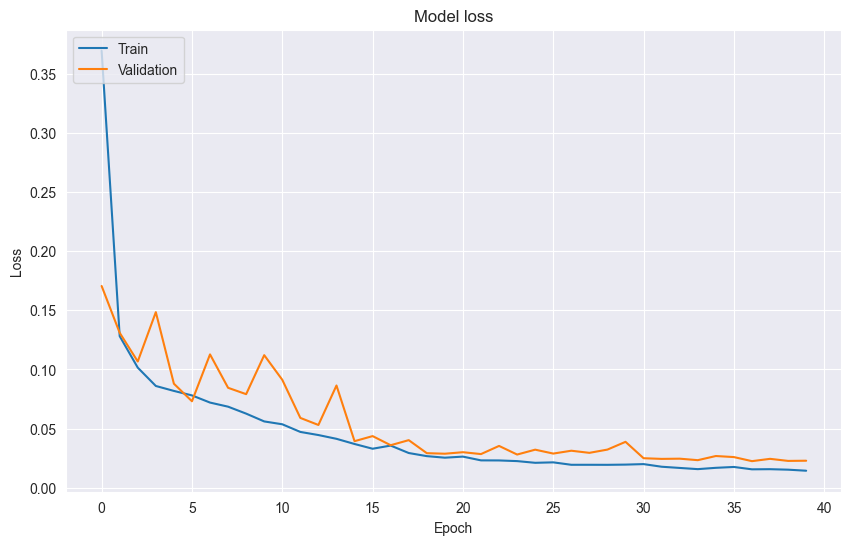

In [10]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()